# Custom Providers Demo

This notebook demonstrates how to create and use custom basis and spectrum providers with the extensible provider architecture.

## Overview

The provider system allows users to:
1. **Create custom basis providers** by inheriting from `BasisProvider`
2. **Create custom spectrum providers** by inheriting from `SpectrumProvider` 
3. **Use template classes** to ensure compatibility with L2Space and SobolevSpace
4. **Extend the system** with new basis types while maintaining clean interfaces

Let's start by setting up the environment and exploring the existing provider architecture.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys

from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.providers import BasisProvider, SpectrumProvider, LazyBasisProvider, LazySpectrumProvider
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.interval.sobolev_space import Sobolev
from pygeoinf.interval.l2_functions import Function

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Understanding the Provider Architecture

Let's first examine the abstract base classes that define the provider interfaces:

In [2]:
# Inspect the abstract base classes
print("BasisProvider abstract methods:")
for method in BasisProvider.__abstractmethods__:
    print(f"  - {method}")

print("\nSpectrumProvider abstract methods:")
for method in SpectrumProvider.__abstractmethods__:
    print(f"  - {method}")

print("\nBasisProvider interface methods:")
basis_methods = [method for method in dir(BasisProvider)
                if not method.startswith('_') or method in ['__getitem__', '__len__', '__iter__']]
for method in basis_methods:
    print(f"  - {method}")

BasisProvider abstract methods:
  - get_basis_function

SpectrumProvider abstract methods:
  - get_eigenvalue
  - get_basis_function

BasisProvider interface methods:
  - __getitem__
  - __iter__
  - __len__
  - get_all_basis_functions
  - get_basis_function


## 2. Example 1: Custom Chebyshev Basis Provider

Let's create a custom basis provider that generates Chebyshev polynomials:

In [3]:
class ChebyshevBasisProvider(BasisProvider):
    """
    Custom basis provider that creates Chebyshev polynomials.

    Chebyshev polynomials T_n(x) are defined on [-1,1] and satisfy:
    - T_0(x) = 1
    - T_1(x) = x
    - T_{n+1}(x) = 2x*T_n(x) - T_{n-1}(x)
    """

    def __init__(self, space):
        super().__init__(space)
        # Transform domain [a,b] to standard Chebyshev domain [-1,1]
        self.a = space.function_domain.a
        self.b = space.function_domain.b
        self._cache = {}

    def get_basis_function(self, index: int):
        """Create Chebyshev polynomial of the given order."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        if index in self._cache:
            return self._cache[index]

        def chebyshev_poly(x):
            # Transform x from [a,b] to [-1,1]
            t = 2 * (x - self.a) / (self.b - self.a) - 1

            # Chebyshev polynomial T_n(t)
            if index == 0:
                return np.ones_like(t)
            elif index == 1:
                return t
            else:
                # Use recurrence relation: T_{n+1} = 2t*T_n - T_{n-1}
                T_prev = np.ones_like(t)  # T_0
                T_curr = t                # T_1

                for n in range(2, index + 1):
                    T_next = 2 * t * T_curr - T_prev
                    T_prev, T_curr = T_curr, T_next

                return T_curr

        func = Function(
            self.space,
            evaluate_callable=chebyshev_poly,
            name=f'T_{index}'
        )
        self._cache[index] = func
        return func

Now let's test our custom Chebyshev provider:

In [4]:
# Create a domain and L2 space
domain = IntervalDomain(0, 1)
space = L2Space(5, domain, basis_type='fourier')  # We'll replace the provider

# Create our custom Chebyshev provider
cheb_provider = ChebyshevBasisProvider(space)

# Test the provider interface
print(f"Provider dimension: {len(cheb_provider)}")
print(f"Can iterate: {hasattr(cheb_provider, '__iter__')}")
print(f"Can index: {hasattr(cheb_provider, '__getitem__')}")

# Get some basis functions
T0 = cheb_provider[0]  # T_0(x) = 1
T1 = cheb_provider[1]  # T_1(x) = t
T2 = cheb_provider[2]  # T_2(x) = 2t² - 1

print(f"\nFunction names: {T0.name}, {T1.name}, {T2.name}")

Provider dimension: 5
Can iterate: True
Can index: True

Function names: T_0, T_1, T_2


Let's visualize the Chebyshev polynomials:

/disks/data/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:258: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


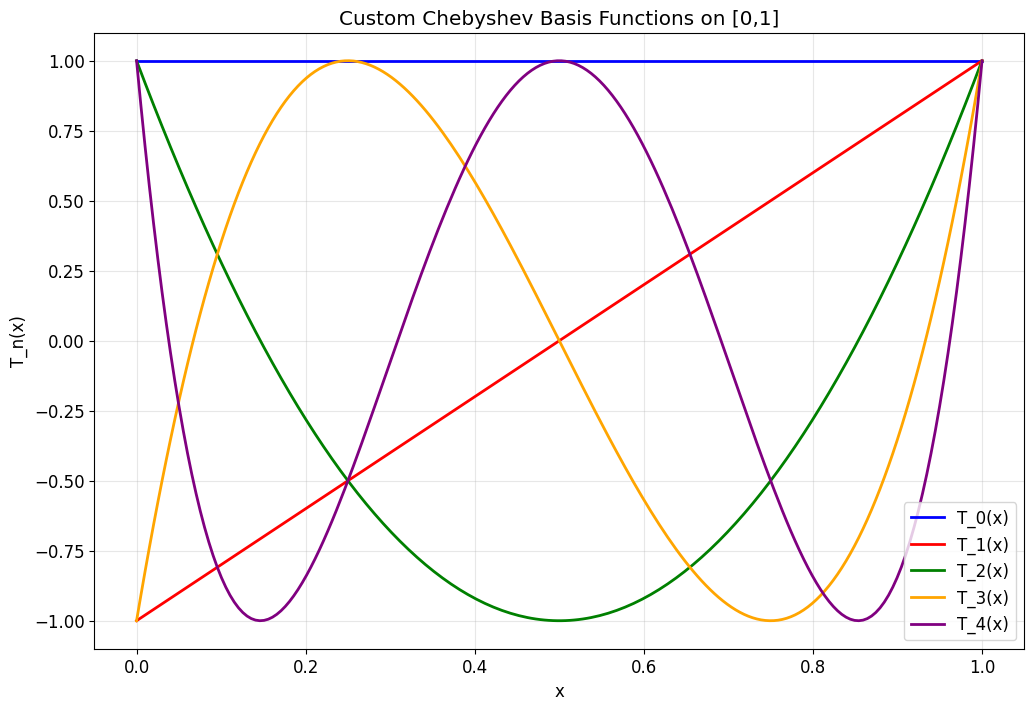


Verifying Chebyshev properties:
T_0(0.5) = 1.000000 (should be 1.0)
T_1(0) = -1.000000 (should be -1.0 after transformation)
T_1(1) = 1.000000 (should be 1.0 after transformation)


In [5]:
# Plot the first few Chebyshev polynomials
x = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i in range(min(5, space.dim)):
    T_i = cheb_provider[i]
    y = T_i(x)
    plt.plot(x, y, color=colors[i], linewidth=2, label=f'T_{i}(x)')

plt.xlabel('x')
plt.ylabel('T_n(x)')
plt.title('Custom Chebyshev Basis Functions on [0,1]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Verify some mathematical properties
print("\nVerifying Chebyshev properties:")
print(f"T_0(0.5) = {T0(0.5):.6f} (should be 1.0)")
print(f"T_1(0) = {T1(0):.6f} (should be -1.0 after transformation)")
print(f"T_1(1) = {T1(1):.6f} (should be 1.0 after transformation)")

## 3. Example 2: Custom Spectrum Provider with Eigenvalues

Now let's create a spectrum provider that includes eigenvalue information:

In [6]:
class ChebyshevSpectrumProvider(SpectrumProvider):
    """
    Custom spectrum provider for Chebyshev polynomials with eigenvalues.

    For demonstration, we'll use eigenvalues λ_n = n² which correspond
    to Chebyshev polynomials being eigenfunctions of some differential operator.
    """

    def __init__(self, space):
        super().__init__(space)
        self.a = space.function_domain.a
        self.b = space.function_domain.b
        self._cache = {}
        # For demonstration, eigenvalues λ_n = n²
        self._eigenvalues = np.array([n**2 for n in range(space.dim)])

    def get_basis_function(self, index: int):
        """Create Chebyshev polynomial (same as ChebyshevBasisProvider)."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        if index in self._cache:
            return self._cache[index]

        def chebyshev_poly(x):
            # Transform x from [a,b] to [-1,1]
            t = 2 * (x - self.a) / (self.b - self.a) - 1

            if index == 0:
                return np.ones_like(t)
            elif index == 1:
                return t
            else:
                T_prev = np.ones_like(t)
                T_curr = t

                for n in range(2, index + 1):
                    T_next = 2 * t * T_curr - T_prev
                    T_prev, T_curr = T_curr, T_next

                return T_curr

        func = Function(
            self.space,
            evaluate_callable=chebyshev_poly,
            name=f'T_{index}'
        )
        self._cache[index] = func
        return func

    def get_eigenvalue(self, index: int):
        """Get eigenvalue for Chebyshev polynomial."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Eigenvalue index {index} out of range [0, {self.space.dim})"
            )
        return self._eigenvalues[index]

Test the spectrum provider:

In [7]:
# Create spectrum provider
cheb_spectrum = ChebyshevSpectrumProvider(space)

# Test spectrum interface
print("Spectrum Provider Interface:")
print(f"Has get_eigenvalue: {hasattr(cheb_spectrum, 'get_eigenvalue')}")
print(f"Has get_eigenfunction: {hasattr(cheb_spectrum, 'get_eigenfunction')}")
print(f"Has get_all_eigenvalues: {hasattr(cheb_spectrum, 'get_all_eigenvalues')}")

# Display eigenvalues
print("\nEigenvalues:")
for i in range(space.dim):
    λ_i = cheb_spectrum.get_eigenvalue(i)
    print(f"λ_{i} = {λ_i}")

# Get all eigenvalues at once
all_eigenvals = cheb_spectrum.get_all_eigenvalues()
print(f"\nAll eigenvalues: {all_eigenvals}")

# Verify that eigenfunction = basis function
phi_2 = cheb_spectrum.get_eigenfunction(2)
T_2 = cheb_spectrum.get_basis_function(2)
print(f"\nEigenfunction and basis function are the same: {phi_2.name == T_2.name}")

Spectrum Provider Interface:
Has get_eigenvalue: True
Has get_eigenfunction: True
Has get_all_eigenvalues: True

Eigenvalues:
λ_0 = 0
λ_1 = 1
λ_2 = 4
λ_3 = 9
λ_4 = 16

All eigenvalues: [0]

Eigenfunction and basis function are the same: True


## 4. Example 3: Sine Basis Provider for Dirichlet BCs

Let's create a provider for sine functions that satisfy Dirichlet boundary conditions:

In [8]:
class SineBasisProvider(BasisProvider):
    """
    Sine basis functions that vanish at boundaries: sin(nπx/L)
    Perfect for homogeneous Dirichlet boundary conditions.
    """

    def __init__(self, space):
        super().__init__(space)
        self.length = space.function_domain.b - space.function_domain.a
        self.a = space.function_domain.a
        self._cache = {}

    def get_basis_function(self, index: int):
        """Create normalized sine basis function."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        if index in self._cache:
            return self._cache[index]

        # Sine functions: sin((n+1)πx/L) for n = 0, 1, 2, ...
        n = index + 1
        freq = n * math.pi / self.length
        normalization = math.sqrt(2 / self.length)  # L²-normalized

        def sine_func(x):
            return normalization * np.sin(freq * (x - self.a))

        func = Function(
            self.space,
            evaluate_callable=sine_func,
            name=f'sin_{n}'
        )
        self._cache[index] = func
        return func


class SineSpectrumProvider(SpectrumProvider):
    """
    Sine spectrum provider with Laplacian eigenvalues.

    For -Δu = λu with u(0) = u(L) = 0:
    Eigenfunctions: sin(nπx/L)
    Eigenvalues: λ_n = (nπ/L)²
    """

    def __init__(self, space):
        super().__init__(space)
        self.length = space.function_domain.b - space.function_domain.a
        self.a = space.function_domain.a
        self._cache = {}
        # Laplacian eigenvalues for sine functions
        self._eigenvalues = np.array([
            ((n+1) * math.pi / self.length)**2 for n in range(space.dim)
        ])

    def get_basis_function(self, index: int):
        """Same as SineBasisProvider."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        if index in self._cache:
            return self._cache[index]

        n = index + 1
        freq = n * math.pi / self.length
        normalization = math.sqrt(2 / self.length)

        def sine_func(x):
            return normalization * np.sin(freq * (x - self.a))

        func = Function(
            self.space,
            evaluate_callable=sine_func,
            name=f'sin_{n}'
        )
        self._cache[index] = func
        return func

    def get_eigenvalue(self, index: int):
        """Get Laplacian eigenvalue for sine function."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Eigenvalue index {index} out of range [0, {self.space.dim})"
            )
        return self._eigenvalues[index]

Visualize the sine basis functions:

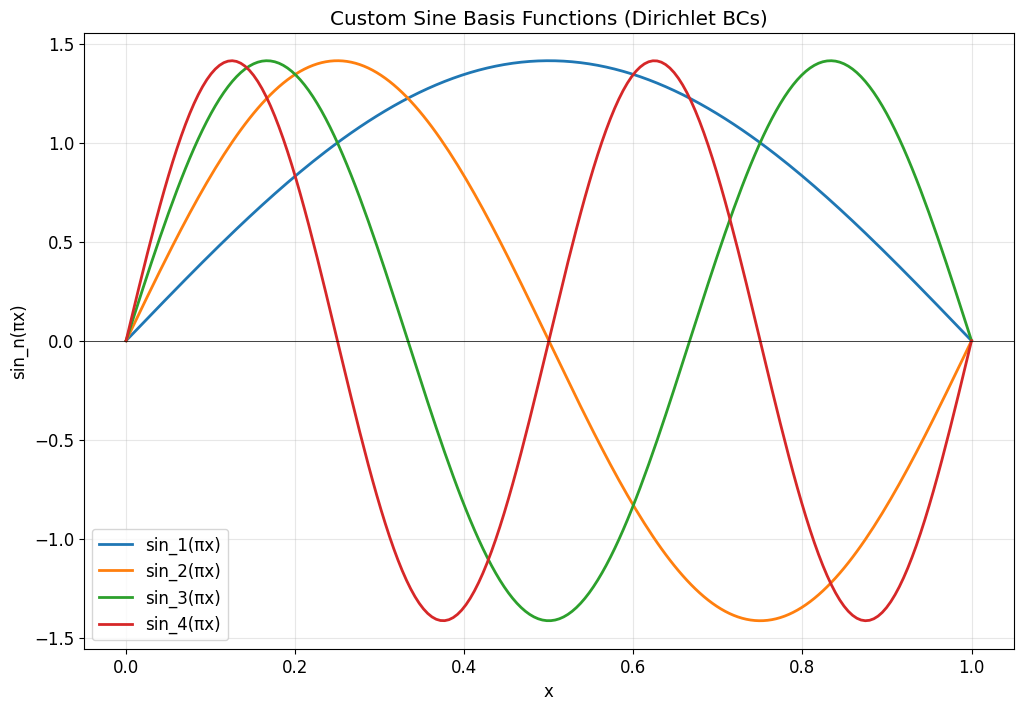

Verifying Dirichlet boundary conditions:
sin_1(0) = 0.0000000000
sin_1(1) = 0.0000000000
sin_2(0) = 0.0000000000
sin_2(1) = -0.0000000000
sin_3(0) = 0.0000000000
sin_3(1) = 0.0000000000

Laplacian eigenvalues:
λ_1 = 9.869604 (expected: 9.869604)
λ_2 = 39.478418 (expected: 39.478418)
λ_3 = 88.826440 (expected: 88.826440)
λ_4 = 157.913670 (expected: 157.913670)
λ_5 = 246.740110 (expected: 246.740110)


In [9]:
# Test sine providers
sine_provider = SineBasisProvider(space)
sine_spectrum = SineSpectrumProvider(space)

# Plot sine basis functions
x = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 8))
for i in range(min(4, space.dim)):
    sin_i = sine_provider[i]
    y = sin_i(x)
    plt.plot(x, y, linewidth=2, label=f'sin_{i+1}(πx)')

plt.xlabel('x')
plt.ylabel('sin_n(πx)')
plt.title('Custom Sine Basis Functions (Dirichlet BCs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.show()

# Verify boundary conditions
print("Verifying Dirichlet boundary conditions:")
for i in range(3):
    sin_i = sine_provider[i]
    print(f"sin_{i+1}(0) = {sin_i(0.0):.10f}")
    print(f"sin_{i+1}(1) = {sin_i(1.0):.10f}")

# Display eigenvalues
print("\nLaplacian eigenvalues:")
for i in range(space.dim):
    λ_i = sine_spectrum.get_eigenvalue(i)
    n = i + 1
    expected = (n * math.pi)**2  # For domain [0,1]
    print(f"λ_{n} = {λ_i:.6f} (expected: {expected:.6f})")

## 5. Using Custom Providers with Spaces

Now let's see how we could integrate custom providers with the space classes. While the current implementation doesn't directly support custom providers, the architecture makes it easy to extend:

In [10]:
# Demonstrate custom provider interface compatibility
print("Provider Interface Compatibility Check:")
print("=" * 50)

providers = {
    'ChebyshevBasisProvider': cheb_provider,
    'ChebyshevSpectrumProvider': cheb_spectrum,
    'SineBasisProvider': sine_provider,
    'SineSpectrumProvider': sine_spectrum
}

# Required interface methods
required_basis = ['get_basis_function', '__getitem__', '__len__', '__iter__']
required_spectrum = required_basis + ['get_eigenvalue', 'get_eigenfunction']

for name, provider in providers.items():
    print(f"\n{name}:")

    # Check if it's a spectrum provider
    is_spectrum = isinstance(provider, SpectrumProvider)
    required = required_spectrum if is_spectrum else required_basis

    print(f"  Type: {'SpectrumProvider' if is_spectrum else 'BasisProvider'}")

    # Check interface methods
    for method in required:
        has_method = hasattr(provider, method)
        status = "✓" if has_method else "✗"
        print(f"  {status} {method}")

    # Test basic functionality
    try:
        func = provider[0]
        test_val = func(0.5)
        print(f"  ✓ Can evaluate: {func.name}(0.5) = {test_val:.6f}")
    except Exception as e:
        print(f"  ✗ Evaluation error: {e}")

    if is_spectrum:
        try:
            eigenval = provider.get_eigenvalue(0)
            print(f"  ✓ Can get eigenvalue: λ_0 = {eigenval}")
        except Exception as e:
            print(f"  ✗ Eigenvalue error: {e}")

Provider Interface Compatibility Check:

ChebyshevBasisProvider:
  Type: BasisProvider
  ✓ get_basis_function
  ✓ __getitem__
  ✓ __len__
  ✓ __iter__
  ✓ Can evaluate: T_0(0.5) = 1.000000

ChebyshevSpectrumProvider:
  Type: SpectrumProvider
  ✓ get_basis_function
  ✓ __getitem__
  ✓ __len__
  ✓ __iter__
  ✓ get_eigenvalue
  ✓ get_eigenfunction
  ✓ Can evaluate: T_0(0.5) = 1.000000
  ✓ Can get eigenvalue: λ_0 = 0

SineBasisProvider:
  Type: BasisProvider
  ✓ get_basis_function
  ✓ __getitem__
  ✓ __len__
  ✓ __iter__
  ✓ Can evaluate: sin_1(0.5) = 1.414214

SineSpectrumProvider:
  Type: SpectrumProvider
  ✓ get_basis_function
  ✓ __getitem__
  ✓ __len__
  ✓ __iter__
  ✓ get_eigenvalue
  ✓ get_eigenfunction
  ✓ Can evaluate: sin_1(0.5) = 1.414214
  ✓ Can get eigenvalue: λ_0 = 9.869604401089358


## 6. Comparing Different Basis Types

Let's compare our custom providers with the built-in Fourier basis:

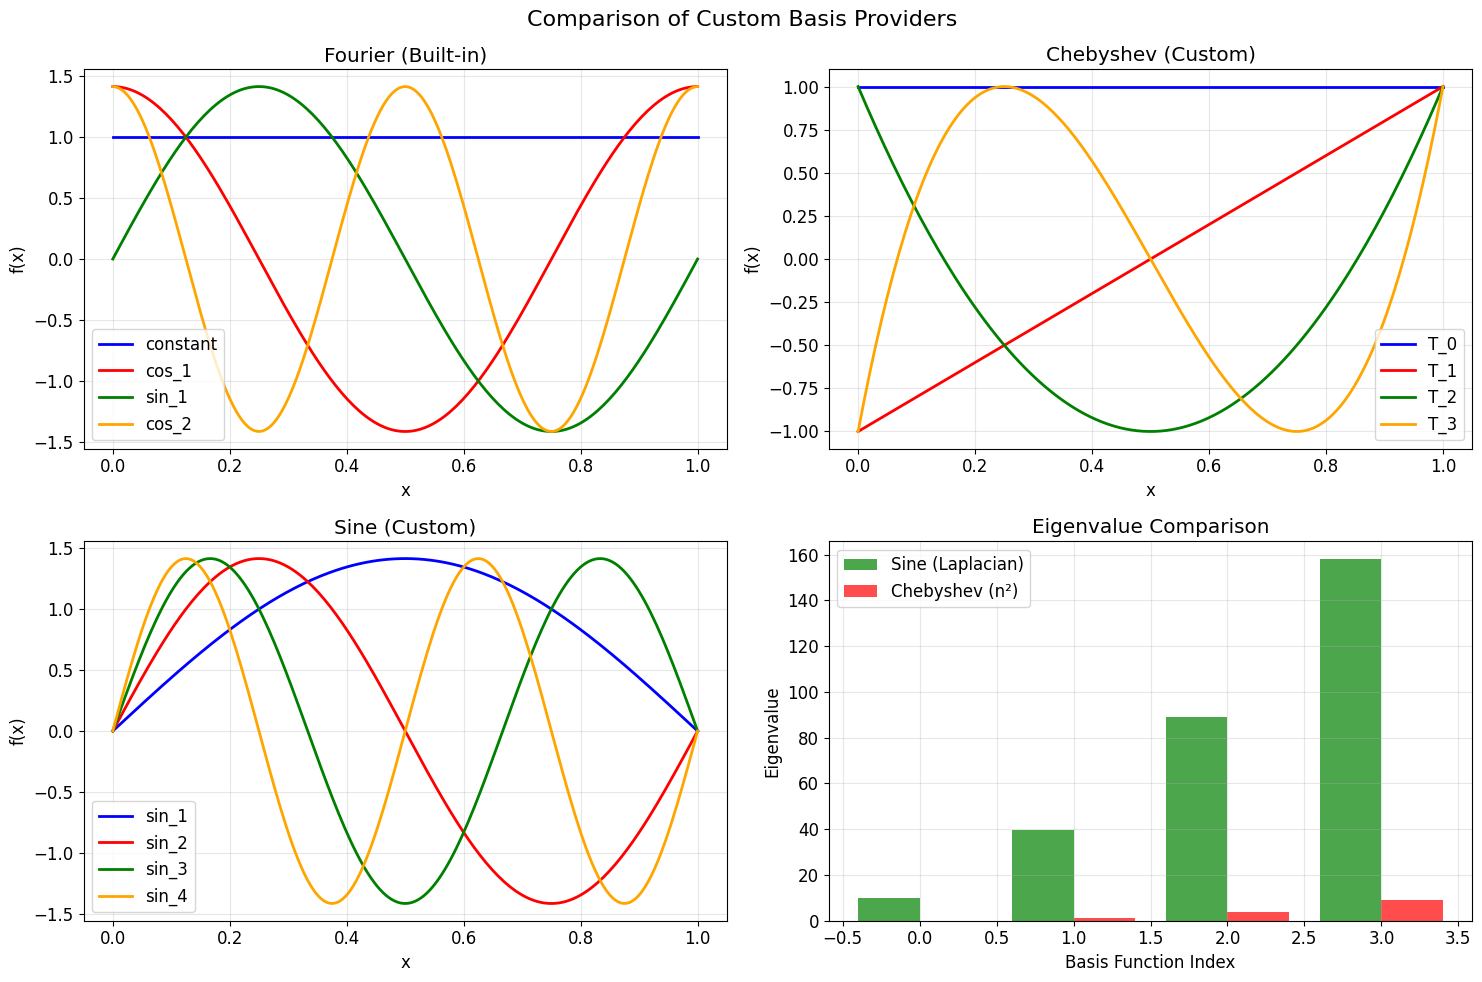

In [11]:
# Create comparison between different basis types
domain = IntervalDomain(0, 1)
space_fourier = L2Space(4, domain, basis_type='fourier')
space_custom = L2Space(4, domain, basis_type='fourier')  # We'll replace this

# Get built-in Fourier provider
fourier_provider = space_fourier.basis_provider

# Create custom providers with same dimension
cheb_provider_4 = ChebyshevBasisProvider(space_custom)
sine_provider_4 = SineBasisProvider(space_custom)

# Compare the first few basis functions
x = np.linspace(0, 1, 200)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of Custom Basis Providers', fontsize=16)

providers_plot = {
    'Fourier (Built-in)': (fourier_provider, axes[0, 0]),
    'Chebyshev (Custom)': (cheb_provider_4, axes[0, 1]),
    'Sine (Custom)': (sine_provider_4, axes[1, 0]),
}

colors = ['blue', 'red', 'green', 'orange']

for title, (provider, ax) in providers_plot.items():
    for i in range(4):
        func = provider[i]
        y = func(x)
        ax.plot(x, y, color=colors[i], linewidth=2, label=func.name)

    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Use the fourth subplot for eigenvalue comparison
ax = axes[1, 1]
sine_spectrum_4 = SineSpectrumProvider(space_custom)
cheb_spectrum_4 = ChebyshevSpectrumProvider(space_custom)

indices = range(4)
sine_eigenvals = [sine_spectrum_4.get_eigenvalue(i) for i in indices]
cheb_eigenvals = [cheb_spectrum_4.get_eigenvalue(i) for i in indices]

ax.bar([i-0.2 for i in indices], sine_eigenvals, width=0.4,
       label='Sine (Laplacian)', alpha=0.7, color='green')
ax.bar([i+0.2 for i in indices], cheb_eigenvals, width=0.4,
       label='Chebyshev (n²)', alpha=0.7, color='red')

ax.set_xlabel('Basis Function Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalue Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Advanced Example: Polynomial Provider with Custom Parameters

Let's create a more sophisticated provider that accepts custom parameters:

In [12]:
class PolynomialBasisProvider(BasisProvider):
    """
    Flexible polynomial basis provider.

    Supports different polynomial types and normalization schemes.
    """

    def __init__(self, space, poly_type='monomial', normalize=True, **kwargs):
        super().__init__(space, **kwargs)
        self.poly_type = poly_type
        self.normalize = normalize
        self.a = space.function_domain.a
        self.b = space.function_domain.b
        self._cache = {}

        # Supported polynomial types
        self.supported_types = ['monomial', 'legendre', 'chebyshev']
        if poly_type not in self.supported_types:
            raise ValueError(f"Unsupported polynomial type: {poly_type}. "
                           f"Supported: {self.supported_types}")

    def get_basis_function(self, index: int):
        """Create polynomial basis function of specified type."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        if index in self._cache:
            return self._cache[index]

        from pygeoinf.interval.l2_functions import Function

        if self.poly_type == 'monomial':
            func = self._create_monomial(index)
        elif self.poly_type == 'legendre':
            func = self._create_legendre(index)
        elif self.poly_type == 'chebyshev':
            func = self._create_chebyshev(index)

        self._cache[index] = func
        return func

    def _create_monomial(self, index):
        """Create monomial x^n."""

        def monomial(x):
            # Transform to [0,1] for simplicity
            t = (x - self.a) / (self.b - self.a)
            result = t**index

            if self.normalize:
                # L² normalization: ||x^n||₂ = 1/√(2n+1) on [0,1]
                norm_factor = math.sqrt(2*index + 1)
                result *= norm_factor

            return result

        return Function(
            self.space,
            evaluate_callable=monomial,
            name=f'x^{index}'
        )

    def _create_legendre(self, index):
        """Create Legendre polynomial."""

        def legendre(x):
            # Transform to [-1,1]
            t = 2 * (x - self.a) / (self.b - self.a) - 1

            # Legendre polynomial P_n(t) using recurrence
            if index == 0:
                result = np.ones_like(t)
            elif index == 1:
                result = t
            else:
                P_prev = np.ones_like(t)  # P_0
                P_curr = t                # P_1

                for n in range(2, index + 1):
                    P_next = ((2*n-1)*t*P_curr - (n-1)*P_prev) / n
                    P_prev, P_curr = P_curr, P_next

                result = P_curr

            if self.normalize:
                # L² normalization: ||P_n||₂ = √(2/(2n+1))
                norm_factor = math.sqrt((2*index + 1) / 2)
                result *= norm_factor

            return result

        return Function(
            self.space,
            evaluate_callable=legendre,
            name=f'P_{index}'
        )

    def _create_chebyshev(self, index):
        """Create Chebyshev polynomial (reuse from earlier)."""

        def chebyshev(x):
            t = 2 * (x - self.a) / (self.b - self.a) - 1

            if index == 0:
                result = np.ones_like(t)
            elif index == 1:
                result = t
            else:
                T_prev = np.ones_like(t)
                T_curr = t

                for n in range(2, index + 1):
                    T_next = 2 * t * T_curr - T_prev
                    T_prev, T_curr = T_curr, T_next

                result = T_curr

            if self.normalize and index > 0:
                # Approximate L² normalization
                result *= math.sqrt(2)

            return result

        return Function(
            self.space,
            evaluate_callable=chebyshev,
            name=f'T_{index}'
        )

Test the flexible polynomial provider:

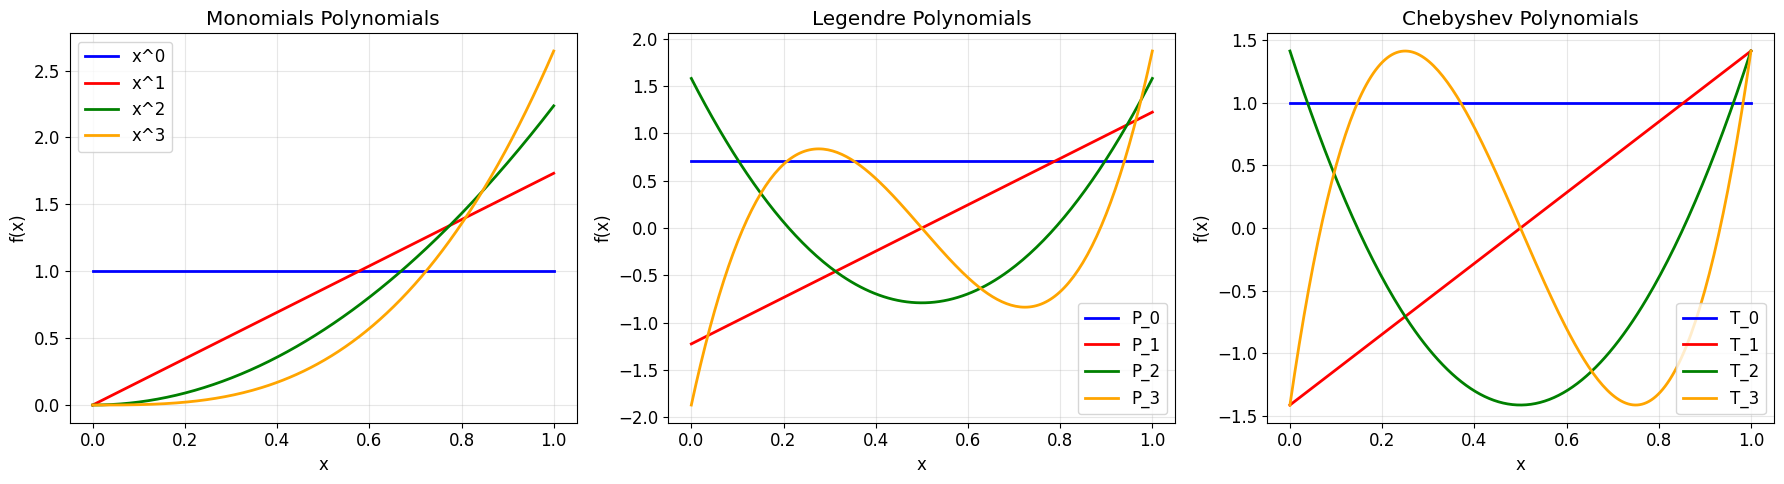

Testing L² normalization (approximate):

Monomials:
  ||x^0||_2 ≈ 1.000000
  ||x^1||_2 ≈ 1.000000
  ||x^2||_2 ≈ 1.000001

Legendre:
  ||P_0||_2 ≈ 0.707107
  ||P_1||_2 ≈ 0.707107
  ||P_2||_2 ≈ 0.707110

Chebyshev:
  ||T_0||_2 ≈ 1.000000
  ||T_1||_2 ≈ 0.816497
  ||T_2||_2 ≈ 0.966095


In [13]:
# Test different polynomial types
space_poly = L2Space(4, domain, basis_type='fourier')  # Placeholder

providers_flexible = {
    'Monomials': PolynomialBasisProvider(space_poly, poly_type='monomial'),
    'Legendre': PolynomialBasisProvider(space_poly, poly_type='legendre'),
    'Chebyshev': PolynomialBasisProvider(space_poly, poly_type='chebyshev')
}

# Plot comparison
x = np.linspace(0, 1, 200)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, provider) in enumerate(providers_flexible.items()):
    ax = axes[i]

    for j in range(4):
        func = provider[j]
        y = func(x)
        ax.plot(x, y, linewidth=2, label=func.name, color=colors[j])

    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(f'{name} Polynomials')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test normalization
print("Testing L² normalization (approximate):")
for name, provider in providers_flexible.items():
    print(f"\n{name}:")
    for i in range(3):
        func = provider[i]

        # Approximate L² norm using numerical integration
        x_fine = np.linspace(0, 1, 1000)
        y = func(x_fine)
        norm_squared = np.trapz(y**2, x_fine)
        norm = math.sqrt(norm_squared)

        print(f"  ||{func.name}||_2 ≈ {norm:.6f}")

## 9. Creating Your Own Custom Provider

Here's a template for creating your own custom provider:

In [14]:
# TEMPLATE: Custom Basis Provider
template_code = '''
class MyCustomBasisProvider(BasisProvider):
    """Template for creating custom basis providers."""

    def __init__(self, space, **kwargs):
        super().__init__(space, **kwargs)
        # Initialize your provider-specific parameters
        self.domain = space.function_domain
        self._cache = {}  # Recommended for performance
        # Add your custom parameters here

    def get_basis_function(self, index: int):
        """REQUIRED: Create basis function for given index."""
        # 1. Validate index
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        # 2. Check cache
        if index in self._cache:
            return self._cache[index]

        # 3. Create function
        from pygeoinf.interval.l2_functions import Function

        def my_basis_function(x):
            # Implement your basis function here
            # Example: return x**index
            return x**index

        func = Function(
            self.space,
            evaluate_callable=my_basis_function,
            name=f'my_basis_{index}'
        )

        # 4. Cache and return
        self._cache[index] = func
        return func


class MyCustomSpectrumProvider(SpectrumProvider):
    """Template for creating custom spectrum providers."""

    def __init__(self, space, **kwargs):
        super().__init__(space, **kwargs)
        self.domain = space.function_domain
        self._cache = {}
        # Compute or store eigenvalues
        self._eigenvalues = self._compute_eigenvalues()

    def get_basis_function(self, index: int):
        """REQUIRED: Same as BasisProvider."""
        # Implement same as above
        pass

    def get_eigenvalue(self, index: int):
        """REQUIRED: Get eigenvalue for given index."""
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Eigenvalue index {index} out of range [0, {self.space.dim})"
            )
        return self._eigenvalues[index]

    def _compute_eigenvalues(self):
        """Compute eigenvalues for your basis functions."""
        # Example: simple polynomial eigenvalues
        return np.array([i**2 for i in range(self.space.dim)])
'''

print("TEMPLATE CODE:")
print(template_code)

print("\nTo use this template:")
print("1. Copy the template code")
print("2. Replace 'MyCustom' with your provider name")
print("3. Implement the basis function logic")
print("4. Add eigenvalue computation (for SpectrumProvider)")
print("5. Test with the interface requirements")
print("6. Use with L2Space or SobolevSpace classes")

TEMPLATE CODE:

class MyCustomBasisProvider(BasisProvider):
    """Template for creating custom basis providers."""

    def __init__(self, space, **kwargs):
        super().__init__(space, **kwargs)
        # Initialize your provider-specific parameters
        self.domain = space.function_domain
        self._cache = {}  # Recommended for performance
        # Add your custom parameters here

    def get_basis_function(self, index: int):
        """REQUIRED: Create basis function for given index."""
        # 1. Validate index
        if not (0 <= index < self.space.dim):
            raise IndexError(
                f"Basis index {index} out of range [0, {self.space.dim})"
            )

        # 2. Check cache
        if index in self._cache:
            return self._cache[index]

        # 3. Create function
        from pygeoinf.interval.l2_functions import Function

        def my_basis_function(x):
            # Implement your basis function here
            # Example: return 